In [1]:
%cd ../

/Users/tahaismail/Desktop/work/Baylor_Hayden/PreyPursuit


In [2]:
import dill as pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, PCA
from legacy.ChangeOfMind.functions import processing as proc
from legacy.controllers import utils as ut
import os
from legacy.PacTimeOrig.data import scripts
from pathlib import Path
from scipy.io import loadmat
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# set directories
# data_dirFI = '/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/figures_cumulative/FisherInfo/FINAL2'
data_dir = 'example_data'

patient_list = ['YFD']
model = 'pv'

# loadd all data
all_data_all_patients = {}
for patient in patient_list:
    path = f'{data_dir}/{patient}/all_data.pkl'
    with open(path, 'rb') as f:
        dat = pickle.load(f)
    all_data_all_patients[patient] = dat

# load tuning info
tuning_all_patients = {}
for patient in patient_list:
    path = f'{data_dir}/{patient}/tuning.pkl'
    with open(path, 'rb') as f:
        dat = pickle.load(f)
    tuning_all_patients[patient] = dat


model_thresh = 0.7
labels = ["speed", "reldist", "relspeed", "reltime", "relvalue", "wt", "wt×reward"]

brain_region = "hpc" # here I select the brain region 

/Users/tahaismail/miniforge3/envs/pac_control_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


total neurons: 546
  speed       : 84
  reldist     : 87
  relspeed    : 62
  reltime     : 89
  relvalue    : 85
  wt          : 94
  wt×reward   : 81


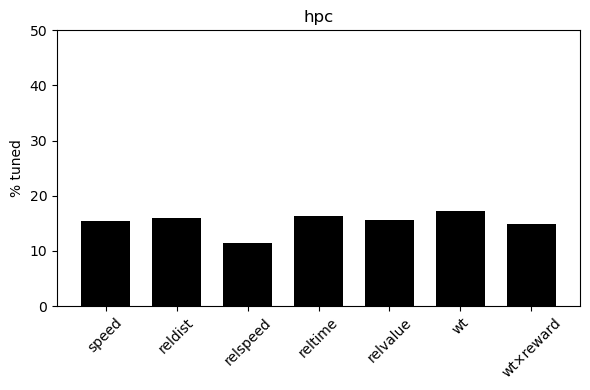

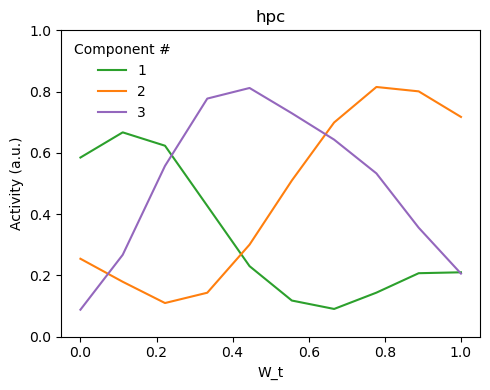

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.ndimage import gaussian_filter1d

# -----------------------------
# 1. OFC % tuned barplot
# -----------------------------

cum_num_ofc = np.zeros(len(labels), float)
cum_den_ofc = 0

for patient in patient_list:
    df = all_data_all_patients[patient].copy()
    df["areas"] = df["areas"].replace({"cingulate": "acc"})

    good = df["model_selection"].values > model_thresh

    x1 = good & df["beta_beta_x1"].apply(lambda v: np.any(np.array(v) != 0)).values
    x2 = good & df["beta_beta_x2"].apply(lambda v: np.any(np.array(v) != 0)).values
    x3 = good & df["beta_beta_x3"].apply(lambda v: np.any(np.array(v) != 0)).values
    x4 = good & df["beta_beta_x4"].apply(lambda v: np.any(np.array(v) != 0)).values
    x6 = good & df["beta_beta_x6"].apply(lambda v: np.any(np.array(v) != 0)).values

    wt_main     = good & df["beta_beta_x5"].apply(lambda v: np.any(np.array(v) != 0)).values
    wt_x_reward = good & df["beta_tensor_x5"].apply(lambda v: np.any(np.array(v) != 0)).values

    tuned = np.column_stack([x1, x2, x3, x4, x6, wt_main, wt_x_reward])

    ofc_mask = df["areas"].eq(brain_region).values
    if ofc_mask.any():
        cum_num_ofc += tuned[ofc_mask].sum(axis=0)
        cum_den_ofc += ofc_mask.sum()

if cum_den_ofc > 0:
    print(f"total neurons: {int(cum_den_ofc)}")
    for lbl, cnt in zip(labels, cum_num_ofc.astype(int)):
        print(f"  {lbl:12s}: {cnt}")

ofc_pct = np.zeros_like(cum_num_ofc) if cum_den_ofc == 0 else 100 * (cum_num_ofc / cum_den_ofc)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(range(len(labels)), ofc_pct, width=0.7, color='black')
ax.set_title(brain_region)
ax.set_ylabel("% tuned")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45)
ax.set_ylim(0, 50)
plt.tight_layout()
# plt.savefig(f"{data_dirFI}/{brain_region}_PrcTuned.svg",
#             transparent=True, bbox_inches='tight', dpi=300)
plt.show()

# -----------------------------
# 2. OFC NMF on Wt tuning
# -----------------------------
tuning_thresh = 0.7  # threshold for selecting neurons for NMF
ofc_rows = []

for patient in patient_list:
    df = all_data_all_patients[patient]
    tuning = tuning_all_patients[patient]

    mask_ofc = (df['areas'] == brain_region) & (df['model_selection'] > tuning_thresh)
    ofc_series = tuning.loc[mask_ofc, 'wt'].dropna()

    for a in ofc_series:
        a = np.asarray(a)
        if a.size == 0:
            continue
        # flatten 2 x 10 matrix -> length 20
        ofc_rows.append(a.T.ravel())

if len(ofc_rows) == 0:
    print("No OFC Wt tuning curves found for NMF.")
else:
    all_ofc_raw = np.vstack(ofc_rows)  # shape: (N_neurons, 20)
    # reshape: (N_neurons, 2, 10) and average across the 2 dimension -> (N_neurons, 10)
    all_ofc = all_ofc_raw.reshape(all_ofc_raw.shape[0], 2, 10).mean(axis=1)

    # NMF on (bins x neurons) = 10 x N
    model = NMF(n_components=5, init='random', random_state=0, l1_ratio=1)
    ofc_nmf = model.fit_transform(all_ofc.T)  # shape: (10, 5)

    n_plot = 3
    colors = ["#2ca02c", "#ff7f0e", "#9467bd"]  # green, orange, purple
    sigma = 1.2

    fig, ax = plt.subplots(figsize=(5, 4))
    x = np.linspace(0, 1, ofc_nmf.shape[0])

    for i in range(n_plot):
        comp = ofc_nmf[:, i]
        comp = (comp - comp.min()) / (comp.max() - comp.min() + 1e-9)
        comp_smooth = gaussian_filter1d(comp, sigma=sigma)
        ax.plot(x, comp_smooth, color=colors[i], label=f"{i+1}")

    ax.set_title(brain_region)
    ax.set_xlabel("W_t")
    ax.set_ylabel("Activity (a.u.)")
    ax.set_ylim([0, 1])
    ax.legend(title="Component #", frameon=False)
    plt.tight_layout()
    # plt.savefig(f"{data_dirFI}/{brain_region}_NNMFAllNeurons.svg",
    #         transparent=True, bbox_inches='tight', dpi=300)
    plt.show()


YEJ: kept 27 trials (relvalue≠0)
YEJ: kept 0 trials (deltarew=0)
YEK: kept 27 trials (relvalue≠0)
YEK: kept 0 trials (deltarew=0)
YEU: kept 46 trials (relvalue≠0)
YEU: kept 32 trials (deltarew=0)
YEW: kept 94 trials (relvalue≠0)
YEW: kept 62 trials (deltarew=0)
YEX: kept 65 trials (relvalue≠0)
YEX: kept 0 trials (deltarew=0)
YEY: kept 102 trials (relvalue≠0)
YEY: kept 0 trials (deltarew=0)
YEZ: kept 64 trials (relvalue≠0)
YEZ: kept 0 trials (deltarew=0)
YFA: kept 69 trials (relvalue≠0)
YFA: kept 0 trials (deltarew=0)
YFB: kept 68 trials (relvalue≠0)
YFB: kept 0 trials (deltarew=0)
YFC: kept 67 trials (relvalue≠0)
YFC: kept 0 trials (deltarew=0)
YFD: kept 138 trials (relvalue≠0)
YFD: kept 0 trials (deltarew=0)
YFE: kept 69 trials (relvalue≠0)
YFE: kept 0 trials (deltarew=0)
YFF: kept 69 trials (relvalue≠0)
YFF: kept 0 trials (deltarew=0)
YFP: kept 107 trials (relvalue≠0)
YFP: kept 62 trials (deltarew=0)
YFQ: kept 56 trials (relvalue≠0)
YFQ: kept 32 trials (deltarew=0)
YFR: kept 56 trial

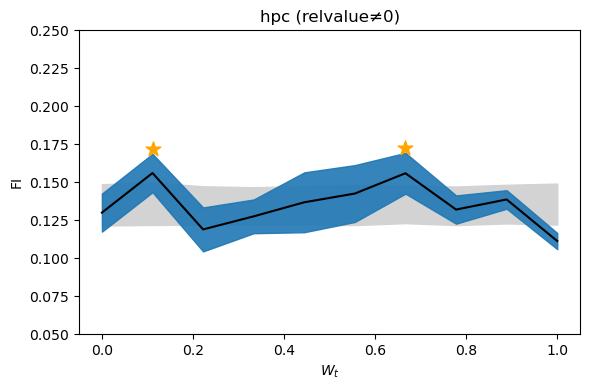

starting permutation (deltarew=0): 0
starting permutation (deltarew=0): 1
starting permutation (deltarew=0): 2
starting permutation (deltarew=0): 3
starting permutation (deltarew=0): 4


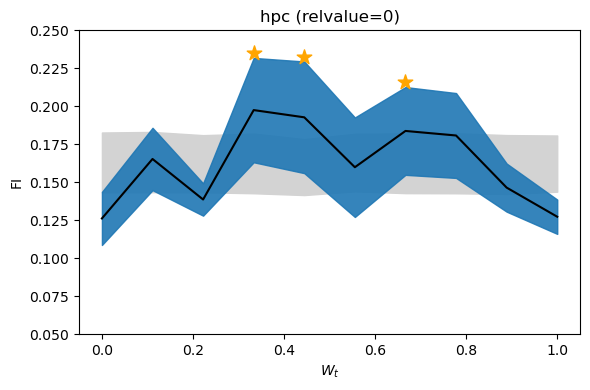

In [62]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


cfgparams = ut.generate_sim_defaults()
cfgparams['rbfs']      = 30
cfgparams['data_path'] = data_dir
cfgparams['scaling']   = 0.001
cfgparams['subjtype']  = 'emu'
cfgparams['folder']    = data_dir
cfgparams['session']   = 1
cfgparams['trialtype'] = '2'

dat = {
    "psth_sess_emu": {},
    "Xd_sess_emu": {},
    "outputs_sess_emu": {},
}
datZero = {
    "psth_sess_emu": {},
    "Xd_sess_emu": {},
    "outputs_sess_emu": {},
}

model = 'pv'

for patient in patient_list:
    cfgparams['subj'] = patient
    Xdsgn, kinematics, sessvars, psth, brainareas = scripts.human_emu_run(cfgparams)

    output_mats = loadmat(Path(data_dir) / patient / model / 'model_matrices.mat')['pt_outs']
    wt = [mat['model_shift'][0, 0][0].reshape(-1, 1) for mat in output_mats.squeeze()]

    # -------- relvalue != 0 --------
    keep_mask = [xd['relvalue'].iloc[0] != 0 for xd in Xdsgn]
    Xdsgn_keep = [xd for xd, keep in zip(Xdsgn, keep_mask) if keep]
    psth_keep  = [p  for p,  keep in zip(psth,  keep_mask) if keep]
    wt_keep    = [w  for w,  keep in zip(wt,   keep_mask) if keep]

    print(f"{patient}: kept {len(Xdsgn_keep)} trials (relvalue≠0)")

    dat["psth_sess_emu"][patient]     = (0, psth_keep)
    dat["Xd_sess_emu"][patient]       = {1: Xdsgn_keep}
    dat["outputs_sess_emu"][patient]  = {1: {'wt_per_trial': wt_keep}}

    # -------- deltarew == 0 --------
    zero_mask = [xd['relvalue'].iloc[0] == 0 for xd in Xdsgn]
    Xdsgn_zero = [xd for xd, keep in zip(Xdsgn, zero_mask) if keep]
    psth_zero  = [p  for p,  keep in zip(psth,  zero_mask) if keep]
    wt_zero    = [w  for w,  keep in zip(wt,   zero_mask) if keep]

    print(f"{patient}: kept {len(Xdsgn_zero)} trials (deltarew=0)")

    datZero["psth_sess_emu"][patient]    = (0, psth_zero)
    datZero["Xd_sess_emu"][patient]      = {1: Xdsgn_zero}
    datZero["outputs_sess_emu"][patient] = {1: {'wt_per_trial': wt_zero}}

# For the first FI analysis we need all_data (concatenated across patients)
all_data = pd.concat(all_data_all_patients.values())

# 2. FI for relvalue≠0 trials (using dat)

ofc_keep = (
    (all_data['areas'] == brain_region) &
    (all_data['beta_beta_x5'].apply(np.sum) > 0) &
    (all_data['model_selection'] > tuning_thresh)
)

FI_ofc_24 = []
null_ofc_runs_24 = []

n_perms = 5
n_boot  = 1000

for nperm in range(n_perms):
    print("starting permutation (relvalue≠0):", nperm)

    all_train, all_test, means = proc.get_kfold_tuning_wt(dat)
    pca = PCA(n_components=0.9, svd_solver="full")

    FI_ofc_tmp = []

    for k in range(5):
        tmp_train = np.stack(all_train[k].iloc[np.where(ofc_keep)[0]]['fr'].values, axis=0)
        tmp_test  = np.stack(all_test[k].iloc[np.where(ofc_keep)[0]]['fr'].values, axis=0)

        pca.fit(tmp_train.T)
        trans = pca.transform(tmp_test.T)
        FI_ofc_tmp.append(np.diagonal(cdist(trans, trans), offset=1))

    FI_ofc_tmp = np.stack(FI_ofc_tmp)             # (folds, bins)
    FI_ofc_24.append(FI_ofc_tmp.mean(axis=0))     # mean over folds

    # permutation null
    flat = FI_ofc_tmp.ravel()
    dist_perm_temp_ofc = []
    F, M = FI_ofc_tmp.shape
    for _ in range(n_boot):
        dist_perm_temp_ofc.append(
            np.random.permutation(flat).reshape(F, M).mean(axis=0)
        )
    dist_perm_temp_ofc = np.stack(dist_perm_temp_ofc)
    null_ofc_runs_24.append(dist_perm_temp_ofc)

FI_ofc_arr_24 = np.stack(FI_ofc_24)         # (n_perms, bins)
null_ofc_stack_24 = np.stack(null_ofc_runs_24, axis=0)  # (n_perms, n_boot, bins)

mu_ofc_24 = FI_ofc_arr_24.mean(axis=0)
sd_ofc_24 = FI_ofc_arr_24.std(axis=0, ddof=1)

# average null across outer repeats, then percentiles across permutations
null_ofc_mean_over_repeats_24 = null_ofc_stack_24.mean(axis=0)  # (n_boot, bins)
null_lo_ofc_24, null_hi_ofc_24 = np.percentile(
    null_ofc_mean_over_repeats_24, [2.5, 97.5], axis=0
)

sig_ofc_24 = mu_ofc_24 > null_hi_ofc_24

x = np.linspace(0, 1, mu_ofc_24.size)

fig, ax = plt.subplots(figsize=(6, 4))
ax.fill_between(x, null_lo_ofc_24, null_hi_ofc_24,
                color='lightgray', alpha=1.0, zorder=1)
ax.fill_between(x, mu_ofc_24 - 1.64*sd_ofc_24, mu_ofc_24 + 1.64*sd_ofc_24,
                color='#1f77b4', alpha=0.9, zorder=2)
ax.plot(x, mu_ofc_24, 'k', zorder=3)

y_star_ofc_24 = (mu_ofc_24 + 1.64*sd_ofc_24) + 0.003
ax.scatter(x[sig_ofc_24], y_star_ofc_24[sig_ofc_24],
           marker='*', s=120, color='orange', zorder=5)

ax.set_title(f"{brain_region} (relvalue≠0)")
ax.set_xlabel(r"$W_t$")
ax.set_ylabel("FI")
ax.set_ylim(0.05, 0.25)

plt.tight_layout()
plt.savefig(f"{data_dirFI}/{brain_region}FI_deltaRew24tuned7.svg",
            transparent=True, bbox_inches='tight', dpi=300)
plt.show()

# 3. FI for deltarew=0 trials 

# prune datZero: remove patients with zero trials
for subj in list(datZero['psth_sess_emu'].keys()):
    trials = datZero['psth_sess_emu'][subj][1]
    if len(trials) == 0:
        datZero['psth_sess_emu'].pop(subj, None)
        datZero['Xd_sess_emu'].pop(subj, None)
        datZero['outputs_sess_emu'].pop(subj, None)

# order of patients used inside folds
patient_order = list(datZero['psth_sess_emu'].keys())

ofc_idx = []
offset = 0
for patient in patient_order:
    dfp = all_data_all_patients[patient].copy()
    dfp['areas'] = dfp['areas'].replace({'cingulate': 'acc'})

    tuned_x5 = (
        dfp['beta_beta_x5'].apply(lambda v: np.any(np.asarray(v) != 0)) &
        (dfp['model_selection'] > tuning_thresh)
    )

    areas = dfp['areas'].values
    n_neurons = len(areas)

    ofc_local = np.where((areas == brain_region) & tuned_x5.values)[0]
    ofc_idx.extend((ofc_local + offset).tolist())

    offset += n_neurons

FI_ofc_0 = []
null_ofc_runs_0 = []

for nperm in range(n_perms):
    print("starting permutation (deltarew=0):", nperm)

    all_train, all_test, means = proc.get_kfold_tuning_wt(datZero)
    # pca = PCA(n_components=4)
    pca = PCA(n_components=0.9, svd_solver="full")

    FI_ofc_tmp = []

    if len(ofc_idx) > 0:
        for k in range(5):
            fold_train = all_train[k].iloc[ofc_idx]
            fold_test  = all_test[k].iloc[ofc_idx]

            tmp_train = np.stack(fold_train['fr'].values, axis=0)
            tmp_test  = np.stack(fold_test['fr'].values, axis=0)

            pca.fit(tmp_train.T)
            
            trans = pca.transform(tmp_test.T)
            FI_ofc_tmp.append(np.diagonal(cdist(trans, trans), offset=1))

    if FI_ofc_tmp:
        FI_ofc_tmp = np.stack(FI_ofc_tmp)      # (folds, bins)
        FI_ofc_0.append(FI_ofc_tmp.mean(axis=0))

        # permutation null
        F, M = FI_ofc_tmp.shape
        flat = FI_ofc_tmp.ravel()
        dist_perm_temp_ofc = []
        for _ in range(n_boot):
            dist_perm_temp_ofc.append(
                np.random.permutation(flat).reshape(F, M).mean(axis=0)
            )
        dist_perm_temp_ofc = np.stack(dist_perm_temp_ofc)
        null_ofc_runs_0.append(dist_perm_temp_ofc)

# stack observed FI
FI_ofc_arr_0 = np.stack(FI_ofc_0)              # (n_runs, bins)
null_ofc_stack_0 = np.stack(null_ofc_runs_0, axis=0)  # (n_runs, n_boot, bins)

mu_ofc_0 = FI_ofc_arr_0.mean(axis=0)
sd_ofc_0 = FI_ofc_arr_0.std(axis=0, ddof=1)

null_ofc_mean_over_repeats_0 = null_ofc_stack_0.mean(axis=0)
null_lo_ofc_0, null_hi_ofc_0 = np.percentile(
    null_ofc_mean_over_repeats_0, [2.5, 97.5], axis=0
)

sig_ofc_0 = mu_ofc_0 > null_hi_ofc_0

x = np.linspace(0, 1, mu_ofc_0.size)

fig, ax = plt.subplots(figsize=(6, 4))
ax.fill_between(x, null_lo_ofc_0, null_hi_ofc_0,
                color='lightgray', alpha=1.0, zorder=1)
ax.fill_between(x, mu_ofc_0 - 1.64*sd_ofc_0, mu_ofc_0 + 1.64*sd_ofc_0,
                color='#1f77b4', alpha=0.9, zorder=2)
ax.plot(x, mu_ofc_0, 'k', zorder=3)

y_star_ofc_0 = (mu_ofc_0 + 1.64*sd_ofc_0) + 0.003
ax.scatter(x[sig_ofc_0], y_star_ofc_0[sig_ofc_0],
           marker='*', s=120, color='orange', zorder=5)

ax.set_title(f"{brain_region} (relvalue=0)")
ax.set_xlabel(r"$W_t$")
ax.set_ylabel("FI")
ax.set_ylim(0.05, 0.25)

plt.tight_layout()
plt.savefig(f"{data_dirFI}/{brain_region}FI_deltaRew0tuned7.svg",
            transparent=True, bbox_inches='tight', dpi=300)
plt.show()


ofc relvalue≠0: 52 neurons
ofc Δrew = 0:  28 neurons
tuning_rel shape:  (52, 11)
tuning_zero shape: (28, 11)


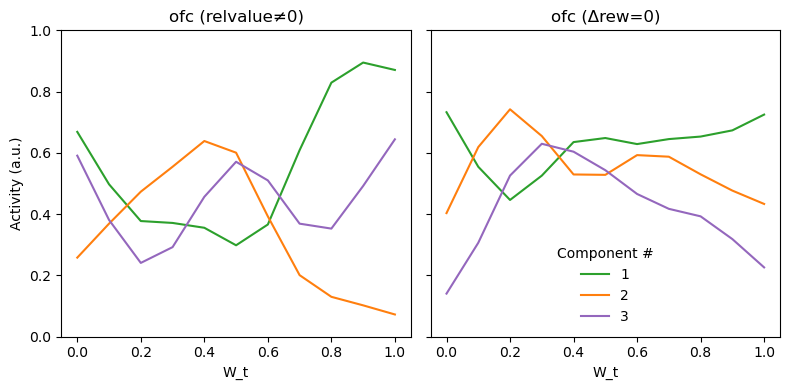

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.ndimage import gaussian_filter1d


def build_region_idx(dat_struct, patient_list_for_dat, brain_region, tuning_thresh):
    """
    Returns: list of neuron indices (global across all patients)
             for this condition & brain region.
    """
    region_idx = []
    offset = 0

    for patient in patient_list_for_dat:
        dfp = all_data_all_patients[patient].copy()
        dfp["areas"] = dfp["areas"].replace({"cingulate": "acc"})

        tuned_x5 = (
            dfp["beta_beta_x5"].apply(lambda v: np.any(np.asarray(v) != 0)) &
            (dfp["model_selection"] > tuning_thresh)
        )

        areas = dfp["areas"].values
        n_neurons = len(areas)

        local = np.where((areas == brain_region) & tuned_x5.values)[0]
        region_idx.extend((local + offset).tolist())

        offset += n_neurons

    return np.array(region_idx, dtype=int)

# ---------------------------------------------------
# Helper: build tuning matrix for a given condition
# ---------------------------------------------------
def build_tuning_matrix(dat_struct, region_idx):
    """
    Returns: matrix (N_neurons, n_bins) of mean tuning across folds.
    """
    all_train, all_test, means = proc.get_kfold_tuning_wt(dat_struct)
    n_folds = len(all_train)

    mats = []
    for k in range(n_folds):
        fold = all_train[k].iloc[region_idx]
        fr_mat = np.stack(fold["fr"].values, axis=0)  # (N_neurons, n_bins)
        mats.append(fr_mat)

    mats = np.stack(mats, axis=0)   # (folds, N_neurons, n_bins)
    return mats.mean(axis=0)        # (N_neurons, n_bins)

# ---------------------------------------------------
# 1) Build indices separately for each condition
# ---------------------------------------------------
patient_order_rel  = list(dat["psth_sess_emu"].keys())
patient_order_zero = list(datZero["psth_sess_emu"].keys())

idx_rel  = build_region_idx(dat,     patient_order_rel,  brain_region, tuning_thresh)
idx_zero = build_region_idx(datZero, patient_order_zero, brain_region, tuning_thresh)

print(f"{brain_region} relvalue≠0: {len(idx_rel)} neurons")
print(f"{brain_region} Δrew = 0:  {len(idx_zero)} neurons")

# ---------------------------------------------------
# 2) Build tuning matrices per condition
# ---------------------------------------------------
tuning_rel  = build_tuning_matrix(dat,     idx_rel)   # (N_rel,  n_bins)
tuning_zero = build_tuning_matrix(datZero, idx_zero)  # (N_zero, n_bins)

print("tuning_rel shape: ",  tuning_rel.shape)
print("tuning_zero shape:", tuning_zero.shape)

# ---------------------------------------------------
# 3) Run NMF separately for each condition
# ---------------------------------------------------
n_components = 5

X_rel  = tuning_rel.T        # (n_bins, N_rel)
X_zero = tuning_zero.T       # (n_bins, N_zero)

model_rel  = NMF(n_components=n_components, init="random",
                 random_state=0, l1_ratio=1)
model_zero = NMF(n_components=n_components, init="random",
                 random_state=0, l1_ratio=1)

W_rel  = model_rel.fit_transform(X_rel)      # (n_bins, n_components)
W_zero = model_zero.fit_transform(X_zero)    # (n_bins, n_components)

# ---------------------------------------------------
# 4) Plot components for the two conditions
# ---------------------------------------------------
n_plot = 3
colors = ["#2ca02c", "#ff7f0e", "#9467bd"]
sigma  = 1.2

def normalize(v):
    return (v - v.min()) / (v.max() - v.min() + 1e-9)

n_bins = W_rel.shape[0]
x = np.linspace(0, 1, n_bins)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for i in range(n_plot):
    # relvalue≠0
    comp_r = normalize(W_rel[:, i])
    comp_r = gaussian_filter1d(comp_r, sigma=sigma)
    axes[0].plot(x, comp_r, color=colors[i], label=f"{i+1}")

    # Δrew = 0
    comp_z = normalize(W_zero[:, i])
    comp_z = gaussian_filter1d(comp_z, sigma=sigma)
    axes[1].plot(x, comp_z, color=colors[i], label=f"{i+1}")

axes[0].set_title(f"{brain_region} (relvalue≠0)")
axes[1].set_title(f"{brain_region} (Δrew=0)")
axes[0].set_xlabel("W_t")
axes[1].set_xlabel("W_t")
axes[0].set_ylabel("Activity (a.u.)")
axes[0].set_ylim([0, 1])

axes[1].legend(title="Component #", frameon=False)

plt.tight_layout()
plt.savefig(f"{data_dirFI}/{brain_region}_NNMF_rel_vs_zero_separate.svg",
            transparent=True, bbox_inches="tight", dpi=300)
plt.show()
